![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Model Editing  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/mjspec.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for model editing in MuJoCo using the `mjSpec` API. This notebook assumes that the reader is already familiar with MuJoCo basic concepts, as
demonstrated in the [introductory tutorial](https://github.com/google-deepmind/mujoco?tab=readme-ov-file#getting-started). Documentation for this API can be found in the [Model Editing](https://mujoco.readthedocs.io/en/latest/programming/modeledit.html) chapter in the documentation (C API) and in the [Python chapter](https://mujoco.readthedocs.io/en/latest/python.html#model-editing). Here we use the Python API.

The goal of the API is to allow users to easily interact with and modify MuJoCo
models in Python, similarly to what the JavaScript DOM does for HTML.

<!-- Copyright 2024 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->


## All imports

In [ ]:
!pip install mujoco

In [1]:

# Set up GPU rendering.
import platform
import distutils.util
import os
import subprocess
if platform.system() != 'Darwin':
  
  if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
      
  # Configure MuJoCo to use the EGL rendering backend (requires GPU)
  print('Setting environment variable to use GPU rendering:')
  %env MUJOCO_GL=egl

  # Check if installation was succesful.
  try:
    print('Checking that the installation succeeded:')
    import mujoco as mj
    mj.MjModel.from_xml_string('<mujoco/>')
  except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else: 
  import mujoco as mj
print('Installation successful.')


# Other imports and helper functions
import numpy as np
import random
from scipy.signal import convolve2d

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Printing.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
import pygments

from IPython.display import clear_output, HTML, display
clear_output()

def print_xml(xml_string):
  formatter = pygments.formatters.HtmlFormatter()
  lexer = pygments.lexers.XmlLexer()
  highlighted = pygments.highlight(xml_string, lexer, formatter)
  display(HTML(f"<style>{formatter.get_style_defs()}</style>{highlighted}"))

def render(model, data=None, height=300, camera=-1):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data, camera)
    media.show_image(renderer.render(), height=height)

# Separate parsing and compiling

Unlike `mj_loadXML` which combines parsing and compiling, when using `mjSpec`, parsing and compiling are separate, allowing for editing steps:


Important commands with `mjSpec`:  
- `add_body`
- `add_geom`
- `add_site`
- `add_actuator`
- `add_[something]`
Adding elements to your model is relatively simple. From the parent body you can add any element and attach it to the parent body. 


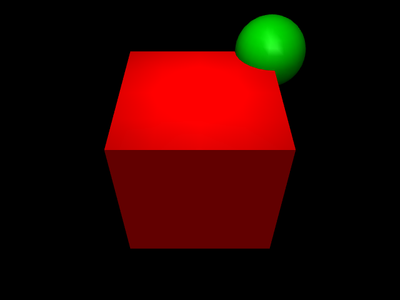


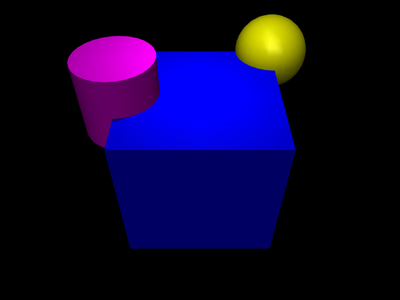

In [2]:
#@title Parse, compile, modify, compile: {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
spec = mj.MjSpec.from_string(static_model)
model = spec.compile()
render(model)

# Change the mjSpec, re-compile and re-render
spec.modelname = "edited model"
geoms = spec.worldbody.find_all(mj.mjtObj.mjOBJ_GEOM)
geoms[0].name = 'blue_box'
geoms[0].rgba = [0, 0, 1, 1]
geoms[1].name = 'yellow_sphere'
geoms[1].rgba = [1, 1, 0, 1]
spec.worldbody.add_geom(name='magenta cylinder',
                        type=mj.mjtGeom.mjGEOM_CYLINDER,
                        rgba=[1, 0, 1, 1],
                        pos=[-.2, 0, .2],
                        size=[.1, .1, 0])

model = spec.compile()
render(model)

`mjSpec` can save XML to string, with all modifications:

In [3]:
print_xml(spec.to_xml())

# Procedural models

In [4]:
#@title {vertical-output: true}

spec = mj.MjSpec()
spec.worldbody.add_light(name="top", pos=[0, 0, 1])
body = spec.worldbody.add_body(name="box_and_sphere",
                               euler=[0, 0, -30])
body.add_joint(name="swing", type=mj.mjtJoint.mjJNT_HINGE,
               axis=[1, -1, 0], pos=[-.2, -.2, -.2])
body.add_geom(name="red_box", type=mj.mjtGeom.mjGEOM_BOX,
              size=[.2, .2, .2], rgba=[1, 0, 0, 1])
body.add_geom(name="green_sphere", pos=[.2, .2, .2],
              size=[.1, 0, 0], rgba=[0, 1, 0, 1])
model = spec.compile()

duration = 2    # (seconds)
framerate = 30  # (Hz)

# enable joint visualization option:
scene_option = mj.MjvOption()
scene_option.flags[mj.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
data = mj.MjData(model)
mj.mj_resetData(model, data)
with mj.Renderer(model) as renderer:
  while data.time < duration:
    mj.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

## Tree

Let's use procedural model creation to make a simple model of a tree.

We'll start with an "arena" xml, containing only a plane and light, and define some utility functions.

In [5]:
#@title Utilities
def branch_frames(num_samples, phi_lower=np.pi / 8, phi_upper=np.pi / 3):
  """Returns branch direction vectors and normalized attachment heights."""
  directions = []
  theta_slice = (2 * np.pi) / num_samples
  phi_slice = (phi_upper - phi_lower) / num_samples
  for i in range(num_samples):
    theta = np.random.uniform(i * theta_slice, (i + 1) * theta_slice)
    phi = phi_lower + np.random.uniform(i * phi_slice, (i + 1) * phi_slice)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    directions.append([x, y, z])

  heights = np.linspace(0.6, 1, num_samples)

  return directions, heights


def add_arrow(scene, from_, to, radius=0.03, rgba=[0.2, 0.2, 0.6, 1]):
  """Add an arrow to the scene."""
  scene.geoms[scene.ngeom].category = mj.mjtCatBit.mjCAT_STATIC
  mj.mjv_initGeom(
      geom=scene.geoms[scene.ngeom],
      type=mj.mjtGeom.mjGEOM_ARROW,
      size=np.zeros(3),
      pos=np.zeros(3),
      mat=np.zeros(9),
      rgba=np.asarray(rgba).astype(np.float32),
  )
  mj.mjv_connector(
      geom=scene.geoms[scene.ngeom],
      type=mj.mjtGeom.mjGEOM_ARROW,
      width=radius,
      from_=from_,
      to=to,
  )
  scene.ngeom += 1


def unit_bump(x, start, end):
  """Finite-support unit bump function."""
  if x <= start or x >= end:
    return 0.0
  else:
    n = (x - start) / (end - start)
    n = 2 * n - 1
    return np.exp(n * n / (n * n - 1))

Our tree creation function is called recursively to add branches and leaves.

In [6]:
# @title Tree creation
def procedural_tree(
    num_child_branch=5,
    length=0.5,
    thickness=0.04,
    depth=4,
    this_body=None,
    spec=None,
):
  """Recursive function that builds a tree of branches and leaves."""
  BROWN = np.array([0.4, 0.24, 0.0, 1])
  GREEN = np.array([0.0, 0.7, 0.2, 1])
  SCALE = 0.6

  # Initialize spec and add tree trunk
  if this_body is None:
    if spec is None:
      spec = mj.MjSpec()

    # Disable constraints
    spec.option.disableflags |= mj.mjtDisableBit.mjDSBL_CONSTRAINT

    # Air density
    spec.option.density = 1.294

    # Defaults for joint and geom
    main = spec.default
    main.geom.type = mj.mjtGeom.mjGEOM_CAPSULE
    main.joint.type = mj.mjtJoint.mjJNT_BALL
    main.joint.springdamper = [0.003, 0.7]

    # Visual
    spec.stat.center = [0, 0, length]
    spec.stat.extent = 2 * length

    # Add trunk body
    this_body = spec.worldbody.add_body(name="trunk")
    fromto = [0, 0, 0, 0, 0, length]
    size = [thickness, 0, 0]
    this_body.add_geom(fromto=fromto, size=size, rgba=BROWN)

  # Sample a random color
  rgba = np.random.uniform(size=4)
  rgba[3] = 1

  # Add child branches using recursive call
  if depth > 0:
    # Get branch direction vectors and attachment heights
    dirs, heights = branch_frames(num_child_branch)
    heights *= length

    # Rescale branches with some randomness
    thickness *= SCALE * np.random.uniform(0.9, 1.1)
    length *= SCALE * np.random.uniform(0.9, 1.1)

    # Branch creation
    for i in range(num_child_branch):
      branch = this_body.add_body(pos=[0, 0, heights[i]], zaxis=dirs[i])

      fromto = [0, 0, 0, 0, 0, length]
      size = [thickness, 0, 0]
      rgba = (rgba + BROWN) / 2
      branch.add_geom(fromto=fromto, size=size, rgba=rgba)

      branch.add_joint()

      # Recurse.
      procedural_tree(
          length=length,
          thickness=thickness,
          depth=depth - 1,
          this_body=branch,
          spec=spec,
      )

  # Max depth reached, add three leaves at the tip
  else:
    rgba = (rgba + GREEN) / 2
    for i in range(3):
      pos = [0, 0, length + thickness]
      euler = [0, 0, i * 120]
      leaf_frame = this_body.add_frame(pos=pos, euler=euler)

      size = length * np.array([0.5, 0.15, 0.01])
      pos = length * np.array([0.45, 0, 0])
      ellipsoid = mj.mjtGeom.mjGEOM_ELLIPSOID
      euler = [np.random.uniform(-50, 50), 0, 0]
      leaf = this_body.add_geom(
          type=ellipsoid, size=size, pos=pos, rgba=rgba, euler=euler
      )

      leaf.set_frame(leaf_frame)

  return spec

In [7]:
#@title Make video
arena_xml = """
<mujoco>
  <visual>
    <headlight diffuse=".5 .5 .5" specular="1 1 1"/>
    <global elevation="-10" offwidth="2048" offheight="1536"/>
    <quality shadowsize="8192"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".5 .5 .5" rgb2="0 0 0" width="10" height="10"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.3"/>
  </asset>

  <worldbody>
    <geom name="floor" size="5 5 0.01" type="plane" material="groundplane"/>
    <light pos="0 0 3" diffuse="1 1 1" specular="1 1 1"/>
  </worldbody>
</mujoco>
"""

spec = procedural_tree(spec=mj.MjSpec.from_string(arena_xml))
model = spec.compile()
data = mj.MjData(model)

duration = 3  # (seconds)
framerate = 60  # (Hz)
frames = []
with mj.Renderer(model, width=1920 // 3, height=1080 // 3) as renderer:
  while data.time < duration:
    # Add rightward wind.
    wind = 40 * unit_bump(data.time, .2 * duration, .7 * duration)
    model.opt.wind[0] = wind

    # Step and render.
    mj.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      if wind > 0:
        add_arrow(renderer.scene, [0, 0, 1], [wind/25, 0, 1])
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate / 2)

# Model editing

In [8]:
# @title Get resources

# Get Models
print('Getting MuJoCo humanoid XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco
humanoid_file = 'mujoco/model/humanoid/humanoid.xml'
humanoid100_file = 'mujoco/model/humanoid/humanoid100.xml'
print('Getting MuJoCo Fly and Franka XML description from GitHub:')
!git clone https://github.com/google-deepmind/mujoco_menagerie
fly_file = 'mujoco_menagerie/flybody/fruitfly.xml'
franka_file = 'mujoco_menagerie/franka_fr3/fr3.xml'

# Camera options
cam = mj.MjvCamera()
mj.mjv_defaultCamera(cam)
cam.elevation = -10
cam.lookat = [0, 0, 1]
cam.distance = 4
cam.azimuth = 135

# Arena
arena_xml = """
<mujoco>
  <visual>
    <headlight diffuse=".5 .5 .5" specular="1 1 1"/>
    <global offwidth="2048" offheight="1536"/>
    <quality shadowsize="8192"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2="1 1 1" width="10" height="10"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="400" height="400"/>
    <material name="groundplane" texture="groundplane" texrepeat="45 45" reflectance="0"/>
  </asset>

  <worldbody>
    <geom name="floor" size="10 10 0.1" type="plane" material="groundplane"/>
  </worldbody>
</mujoco>
"""


Getting MuJoCo humanoid XML description from GitHub:
Cloning into 'mujoco'...
remote: Enumerating objects: 31885, done.
remote: Counting objects: 100% (1443/1443), done.
remote: Compressing objects: 100% (554/554), done.
remote: Total 31885 (delta 1080), reused 890 (delta 888), pack-reused 30442 (from 5)
Receiving objects: 100% (31885/31885), 110.14 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (24558/24558), done.
Getting MuJoCo Fly and Franka XML description from GitHub:
Cloning into 'mujoco_menagerie'...
remote: Enumerating objects: 5811, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 5811 (delta 12), reused 11 (delta 7), pack-reused 5785 (from 2)
Receiving objects: 100% (5811/5811), 413.26 MiB | 3.54 MiB/s, done.
Resolving deltas: 100% (1928/1928), done.
Updating files: 100% (2108/2108), done.


`mjSpec` elements can be traversed in two ways:
- For elements inside the kinematic tree, the tree can be traversed using the `first` and `next` functions.
- For all other elements, we provide a list.



In [9]:
#@title Traversing the spec {vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)

# Function that recursively prints all body names
def print_bodies(parent, level=0):
  body = parent.first_body()
  while body:
    print(''.join(['-' for i in range(level)]) + body.name)
    print_bodies(body, level + 1)
    body = parent.next_body(body)

print("The spec has the following actuators:")
for actuator in spec.actuators:
  print(actuator.name)

print("\nThe spec has the following bodies:")
print_bodies(spec.worldbody)

The spec has the following actuators:
abdomen_z
abdomen_y
abdomen_x
hip_x_right
hip_z_right
hip_y_right
knee_right
ankle_y_right
ankle_x_right
hip_x_left
hip_z_left
hip_y_left
knee_left
ankle_y_left
ankle_x_left
shoulder1_right
shoulder2_right
elbow_right
shoulder1_left
shoulder2_left
elbow_left

The spec has the following bodies:
torso
-head
-waist_lower
--pelvis
---thigh_right
----shin_right
-----foot_right
---thigh_left
----shin_left
-----foot_left
-upper_arm_right
--lower_arm_right
---hand_right
-upper_arm_left
--lower_arm_left
---hand_left


An `mjSpec` can be compiled multiple times. If the state has to be preserved between different compilations, then the function `recompile()` must be used, which returns a new `mjData` that contains the mapped state, possibly having a different dimension from the origin.


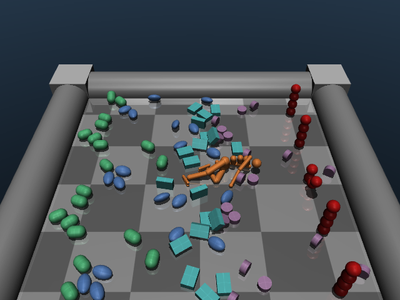


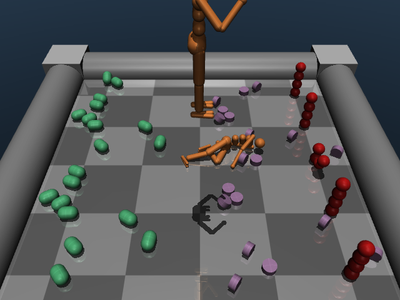

In [10]:
#@title Model re-compilation with state preservation {vertical-output: true}

spec = mj.MjSpec.from_file(humanoid100_file)
model = spec.compile()
data = mj.MjData(model)

# Run for 5 seconds
for i in range(1000):
  mj.mj_step(model, data)

# Show result
render(model, data)

# Create list of all bodies we want to delete
body = spec.worldbody.first_body()
delete_list = []
while body:
  geom_type = body.first_geom().type
  if (geom_type == mj.mjtGeom.mjGEOM_BOX or
      geom_type == mj.mjtGeom.mjGEOM_ELLIPSOID):
    delete_list.append(body)
  body = spec.worldbody.next_body(body)

# Remove all bodies in the list from the spec
for body in delete_list:
  spec.detach_body(body)

# # Add another humanoid
spec_humanoid = mj.MjSpec.from_file(humanoid_file)
attachment_frame = spec.worldbody.add_frame(pos=[0, -1, 2])
attachment_frame.attach_body(spec_humanoid.body('torso'), 'a', 'b')

# Recompile preserving the state
new_model, new_data = spec.recompile(model, data)

# Show result
render(new_model, new_data)

Let us load the humanoid model and inspect it.

In [ ]:
#@title Humanoid model {vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)

model = spec.compile()
render(model)

We wish to remove the arms and replace them with the legs. This can be done by first storing the arm positions into frames attached to the torso. Then we can detach the arms and self-attach the legs into the frames.

In [ ]:
#@title Humanoid with arms replaced by legs {vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)
spec.copy_during_attach = True

# Get the torso, arm, and leg bodies
arm_left = spec.body('upper_arm_left')
arm_right = spec.body('upper_arm_right')
leg_left = spec.body('thigh_left')
leg_right = spec.body('thigh_right')
torso = spec.body('torso')

# Attach frames at the arm positions
shoulder_left = torso.add_frame(pos=arm_left.pos)
shoulder_right = torso.add_frame(pos=arm_right.pos)

# Remove the arms
spec.detach_body(arm_left)
spec.detach_body(arm_right)

# Add new legs
shoulder_left.attach_body(leg_left, 'shoulder', 'left')
shoulder_right.attach_body(leg_right, 'shoulder', 'right')

model = spec.compile()
render(model, height=400)

Similarly, different models can be attach together. Here, the right arm is detached and a robot arm from a different model is attached in its place.

In [ ]:
#@title Humanoid with Franka arm {vertical-output: true}

spec = mj.MjSpec.from_file(humanoid_file)
franka = mj.MjSpec.from_file(franka_file)

if hasattr(spec, 'compiler'):
  spec.compiler.degree = False  # MuJoCo dev (next release).
else:
  spec.degree = False  # MuJoCo release

# Replace right arm with frame
arm_right = spec.body('upper_arm_right')
torso = spec.body('torso')
shoulder_right = torso.add_frame(pos=arm_right.pos, quat=[0, 0.8509035, 0, 0.525322])
spec.detach_body(arm_right)

# Attach Franka arm to humanoid
franka_arm = franka.body('fr3_link2')
shoulder_right.attach_body(franka_arm, 'franka', '')

model = spec.compile()
render(model, height=400)

When doing this, the actuators and all other objects referenced by the attached sub-tree are imported in the new model. All assets are currently imported, referenced or not.

In [ ]:
#@title Imported actuators {vertical-output: true}

for actuator in spec.actuators:
  print(actuator.name)

Domain randomization can be performed by attaching multiple times the same spec, edited each time with a new instance of randomized parameters.

In [ ]:
#@title Humanoid with randomized heads and arm poses {vertical-output: true}

humanoid = mj.MjSpec.from_file(humanoid_file)
spec = mj.MjSpec()
spec.copy_during_attach = True

# Delete all key frames to avoid name conflicts
while humanoid.keys:
  humanoid.keys[-1].delete()

# Create a grid of humanoids by attaching humanoid to spec multiple times
for i in range(4):
  for j in range(4):
    humanoid.materials[0].rgba = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), 1]  # Randomize color
    humanoid.body('head').first_geom().size = [
        .18*np.random.uniform(), 0, 0]  # Randomize head size
    humanoid.body('upper_arm_left').quat = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), np.random.uniform()]  # Randomize left arm orientation
    humanoid.body('upper_arm_right').quat = [
        np.random.uniform(), np.random.uniform(),
        np.random.uniform(), np.random.uniform()]  # Randomize right arm orientation

    # attach randomized humanoid to parent spec
    frame = spec.worldbody.add_frame(pos=[i, j, 0])
    frame.attach_body(humanoid.body('torso'), str(i), str(j))

spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='3torso3', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()
render(model, height=400)

## Model scaling

In [ ]:
#@title Uniformly scale humanoid {vertical-output: true}

def scale_spec(spec, scale):
  scaled_spec = spec.copy()
  # Traverse the kinematic tree, scaling all geoms
  def scale_bodies(parent, scale=1.0):
    body = parent.first_body()
    while body:
      if body.pos is not None:
        body.pos = body.pos * scale
      for geom in body.geoms:
        geom.fromto = geom.fromto * scale
        geom.size = geom.size * scale
        if geom.pos is not None:
          geom.pos = geom.pos * scale
      scale_bodies(body, scale)
      body = parent.next_body(body)

  scale_bodies(scaled_spec.body('world'), scale)
  return scaled_spec

spec = mj.MjSpec.from_string(arena_xml)
humanoid = mj.MjSpec.from_file(humanoid_file)
small_humanoid = scale_spec(humanoid, 0.75)
large_humanoid = scale_spec(humanoid, 1.25)

# Create a line-up of humanoids
frame = spec.worldbody.add_frame(pos=[-1, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(humanoid.body('torso'), str(0))

frame = spec.worldbody.add_frame(pos=[0, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(small_humanoid.body('torso'), str(1))

frame = spec.worldbody.add_frame(pos=[1, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2]  )
frame.attach_body(large_humanoid.body('torso'), str(2))


spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='1torso', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()
render(model, height=400, camera=cam)

We can scale the size of a model by traversing the kinematic tree and applying the scale to the relevant geoms. Above we can see humanoids of three different sizes.

In [ ]:
# @title Scaling actuator forces {vertical-output: true}

def scale_spec(spec, scale, scale_actuators=False):
  scaled_spec = spec.copy()
  # Traverse the kinematic tree, scaling all geoms
  def scale_bodies(parent, scale=1.0):
    body = parent.first_body()
    while body:
      if body.pos is not None:
        body.pos = body.pos * scale
      for geom in body.geoms:
        geom.fromto = geom.fromto * scale
        geom.size = geom.size * scale
        if geom.pos is not None:
          geom.pos = geom.pos * scale
      scale_bodies(body, scale)
      body = parent.next_body(body)

  if scale_actuators:
    # scale gear
    for actuator in scaled_spec.actuators:
      # scale the actuator gear by (scale ** 2),
      # this is because muscle force-generating capacity
      # scales with the cross-sectional area of the muscle
      actuator.gear = actuator.gear * scale * scale

  # scale the z-position of the humanoid for all keypoints
  for keypoint in scaled_spec.keys:
    qpos = keypoint.qpos
    qpos[2] = qpos[2] * scale
    keypoint.qpos = qpos
    keypoint.qpos[2] = keypoint.qpos[2] * scale

  scale_bodies(scaled_spec.body('world'), scale)
  return scaled_spec

# Create specs
scale = 0.6
spec = mj.MjSpec.from_string(arena_xml)
humanoid = mj.MjSpec.from_file(humanoid_file)
small_humanoid = scale_spec(humanoid, scale)
small_humanoid_actuators_scaled = scale_spec(humanoid, scale, True)

# Create a line-up of humanoids
squat_qpos = []

# Add unscaled humanoid
frame = spec.worldbody.add_frame(pos=[-1, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(humanoid.body('torso'), str(0))
# Record squat pose
humanoid_squat = humanoid.key('squat').qpos
humanoid_squat[:2] = frame.pos[:2]
humanoid_squat[3:7] = frame.quat
squat_qpos.append(humanoid_squat)

# Add small humanoid
frame = spec.worldbody.add_frame(pos=[0, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(small_humanoid.body('torso'), str(1))
# Record squat pose
humanoid_squat = small_humanoid.key('squat').qpos
humanoid_squat[:2] = frame.pos[:2]
humanoid_squat[3:7] = frame.quat
squat_qpos.append(humanoid_squat)

# Add small humanoid with scaled actuators
frame = spec.worldbody.add_frame(pos=[1, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2]  )
frame.attach_body(small_humanoid_actuators_scaled.body('torso'), str(2))
# Record squat pose
humanoid_squat = small_humanoid_actuators_scaled.key('squat').qpos
humanoid_squat[:2] = frame.pos[:2]
humanoid_squat[3:7] = frame.quat
squat_qpos.append(humanoid_squat)
squat_qpos = np.concatenate(squat_qpos)

spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='1torso', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()

# Initialize to squat position
data = mj.MjData(model)
data.qpos = squat_qpos

# jumping motion
u_t = lambda t: 10.0 * t / duration

# Simulate and display video.
duration = 2    # (seconds)
framerate = 30  # (Hz)
frames = []

with mj.Renderer(model, 480, 640) as renderer:
  while data.time < duration:
    data.ctrl = u_t(data.time)
    mj.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, camera=cam)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate, height=400)

We can also apply scaling to the actuators. In the humanoid case, scaling the geoms without scaling the `gear` parameter for the actuators results in a humanoid that can jump higher proportional to its size.

In [ ]:
# @title Long-limbed humanoid {vertical-output: true}

def scale_spec(spec, scale):
  scaled_spec = spec.copy()
  # Traverse the kinematic tree, scaling all geoms
  def scale_bodies(parent, scale=1.0):
    if parent is not None:
      for geom in parent.geoms:
        # Only scale fromto, not size to scale length of capsules
        geom.fromto = geom.fromto * scale
        if geom.pos is not None:
          geom.pos = geom.pos * scale
    body = parent.first_body()
    while body:
      if body.pos is not None:
        body.pos = body.pos * scale
      scale_bodies(body, scale)
      body = parent.next_body(body)

  # Scale all the limbs
  scale_bodies(scaled_spec.body('upper_arm_right'), scale)
  scale_bodies(scaled_spec.body('upper_arm_left'), scale)
  scale_bodies(scaled_spec.body('thigh_right'), scale)
  scale_bodies(scaled_spec.body('thigh_left'), scale)
  return scaled_spec

spec = mj.MjSpec.from_string(arena_xml)
humanoid = mj.MjSpec.from_file(humanoid_file)
small_humanoid = scale_spec(humanoid, 1.25)
large_humanoid = scale_spec(humanoid, 2)

# Create a line-up of humanoids by attaching
frame = spec.worldbody.add_frame(pos=[-1, 0, 0],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(humanoid.body('torso'), str(0), str(0))

frame = spec.worldbody.add_frame(pos=[0, 0, 0.2],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(small_humanoid.body('torso'), str(0), str(1))

frame = spec.worldbody.add_frame(pos=[1, 0, 0.8],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2]  )
frame.attach_body(large_humanoid.body('torso'), str(0), str(2))


spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='0torso1', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()

# camera options
render(model, height=400, camera=cam)

We can also apply scaling to the model non-uniformly. In this instance we scale the humanoid to have long limbs, by only applying the scale to the length of the capsule geoms for the arms, legs and feet.

In [ ]:
# @title Meshes {vertical-output: true}

def scale_spec(spec, scale):
  scaled_spec = spec.copy()
  # scale all meshes
  for mesh in scaled_spec.meshes:
    if mesh.scale is None:
      mesh.scale = np.ones(3)
    mesh.scale = mesh.scale * scale

  # Traverse the kinematic tree
  def scale_bodies(parent, scale=1.0):
    if parent is not None:
      for geom in parent.geoms:
        if geom.pos is not None:
          geom.pos = geom.pos * scale
    body = parent.first_body()
    while body:
      if body.pos is not None:
        body.pos = body.pos * scale
      scale_bodies(body, scale)
      body = parent.next_body(body)

  # Scale all the limbs
  scale_bodies(scaled_spec.body('world'), scale)

  return scaled_spec

spec = mj.MjSpec.from_string(arena_xml)
fly = mj.MjSpec.from_file(fly_file)
# Remove lights from fly so they are not duplicated in line-up
for light in fly.lights:
  light.delete()

small_fly = scale_spec(fly, 1.25)
large_fly = scale_spec(fly, 2)

# Create a line-up of flys by attaching
frame = spec.worldbody.add_frame(pos=[-1, 0, 0.25],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(fly.body('thorax'), str(0), str(0))

frame = spec.worldbody.add_frame(pos=[0, 0, 0.25],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2])
frame.attach_body(small_fly.body('thorax'), str(0), str(1))

frame = spec.worldbody.add_frame(pos=[1, 0, 0.25],
                                 quat=[-np.sqrt(2)/2, 0, 0, np.sqrt(2) / 2]  )
frame.attach_body(large_fly.body('thorax'), str(0), str(2))

spec.worldbody.add_light(mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODYCOM,
                         targetbody='0thorax1', diffuse=[.8, .8, .8],
                         specular=[0.3, 0.3, 0.3], pos=[0, -6, 4], cutoff=30)
model = spec.compile()
render(model, height=400, camera=cam)


# dm_control example

A key feature is the ability to easily attach multiple models into a larger one. Disambiguation of duplicated names from different
models, or multiple instances of the same model is handled via user-defined namespacing.

One example use case is when we want robots with a variable number of joints, as this is a fundamental change to the kinematic structure. The snippets below follow the lines of the [example in dm_control](https://arxiv.org/abs/2006.12983), an older package with similar capabilities.

In [ ]:
leg_model = """
<mujoco>
  <compiler angle="radian"/>

  <default>
    <joint damping="2" type="hinge"/>
    <geom type="capsule"/>
  </default>

  <worldbody>
    <body name="thigh">
      <joint name="hip" axis="0 0 1"/>
      <body name="shin">
        <joint name="knee" axis="0 1 0"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <position joint="hip" kp="10" name="hip"/>
    <position joint="knee" kp="10" name="knee"/>
  </actuator>
</mujoco>
"""

class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.spec = mj.MjSpec.from_string(leg_model)

    # Thigh:
    thigh = self.spec.body('thigh')
    thigh.add_geom(fromto=[0, 0, 0, length, 0, 0], size=[length/4, 0, 0], rgba=rgba)

    # Hip:
    shin = self.spec.body('shin')
    shin.add_geom(fromto=[0, 0, 0, 0, 0, -length], size=[length/5, 0, 0], rgba=rgba)
    shin.pos[0] = length

The `Leg` class describes an abstract articulated leg, with two joints and corresponding proportional-derivative actuators.

Note that:

- MJCF attributes correspond directly to arguments of the `add_()` methods.
- When referencing elements, e.g. when specifying the joint to which an actuator is attached, the name string of the MJCF elements is used.

In [ ]:
BODY_RADIUS = 0.1
random_state = np.random.RandomState(42)
creature_model = """
<mujoco>
  <compiler angle="radian"/>

  <worldbody>
    <geom name="torso" type="ellipsoid" size="{} {} {}"/>
  </worldbody>
</mujoco>
""".format(BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  spec = mj.MjSpec.from_string(creature_model)
  spec.copy_during_attach = True

  # Attach legs to equidistant sites on the circumference.
  spec.worldbody.first_geom().rgba = rgba
  leg = Leg(length=BODY_RADIUS, rgba=rgba)
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = spec.worldbody.add_site(pos=hip_pos, euler=[0, 0, theta])
    hip_site.attach_body(leg.spec.body('thigh'), '', '-' + str(i))

  return spec

The `make_creature` function uses the `attach()` method to procedurally attach legs to the torso. Note that at this stage both the torso and hip attachment sites are children of the `worldbody`, since their parent body has yet to be instantiated. We'll now make an arena with a chequered floor and two lights, and place our creatures in a grid.

In [ ]:
#@title Six Creatures on a floor {vertical-output: true}

arena = mj.MjSpec()

if hasattr(arena, 'compiler'):
  arena.compiler.degree = False  # MuJoCo dev (next release).
else:
  arena.degree = False  # MuJoCo release

# Make arena with textured floor.
chequered = arena.add_texture(
    name="chequered", type=mj.mjtTexture.mjTEXTURE_2D,
    builtin=mj.mjtBuiltin.mjBUILTIN_CHECKER,
    width=300, height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.add_material(
    name='grid', texrepeat=[5, 5], reflectance=.2
    ).textures[mj.mjtTextureRole.mjTEXROLE_RGB] = 'chequered'
arena.worldbody.add_geom(
    type=mj.mjtGeom.mjGEOM_PLANE, size=[2, 2, .1], material='grid')
for x in [-2, 2]:
  arena.worldbody.add_light(pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, spec in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add_site(pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_body = spawn_site.attach_body(spec.worldbody, '', '-' + str(i))
  spawn_body.add_freejoint()

# Instantiate the physics and render.
model = arena.compile()
render(model)

Multi-legged creatures, ready to roam! Let's inject some controls and watch them move. We'll generate a sinusoidal open-loop control signal of fixed frequency and random phase, recording both video frames and the horizontal positions of the torso geoms, in order to plot the movement trajectories.

In [ ]:
#@title Video of the movement {vertical-output: true}

data = mj.MjData(model)
duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
geoms = arena.worldbody.find_all(mj.mjtObj.mjOBJ_GEOM)
torsos_data = [data.bind(geom) for geom in geoms if 'torso' in geom.name]
torsos_model = [model.bind(geom) for geom in geoms if 'torso' in geom.name]
actuators = [data.bind(actuator) for actuator in arena.actuators]

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(arena.actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
mj.mj_resetData(model, data)
with mj.Renderer(model) as renderer:
  while data.time < duration:
    # Inject controls and step the physics.
    for i, actuator in enumerate(actuators):
      actuator.ctrl = amp * np.sin(freq * data.time + phase[i])
    mj.mj_step(model, data)

    # Save torso horizontal positions using name indexing.
    pos_x.append([torso.xpos[0] for torso in torsos_data])
    pos_y.append([torso.xpos[1] for torso in torsos_data])

    # Save video frames.
    if len(video) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      video.append(pixels.copy())

media.show_video(video, fps=framerate)

In [ ]:
#@title Movement trajectories {vertical-output: true}

creature_colors = [torso.rgba[:3] for torso in torsos_model]
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

The plot above shows the corresponding movement trajectories of creature positions. Note how `mjSpec` attribute `id` were used to access both `xpos` and `rgba` values. This attribute is valid only after a model is compiled.